In [1]:
DATASET_PATH  = "Augmented Datasets/"
FEVER_PLUS_PATH = 'tommasobonomo/sem_augmented_fever_nli'
ADVERSARIAL_FEVER_PATH = 'https://huggingface.co/datasets/iperbole/adversarial_fever_nli'

# Decide if you want to train DeBerta coupled models or not (in thatcase, just finetune the fc)
FREEZE_BACKBONE = True

In [2]:
# import torch
# import torch.nn as nn
# from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification

# class TwinnedModel(nn.Module):
#     def __init__(self, do_finetuning, model_name1='microsoft/deberta-v3-xsmall', model_name2='microsoft/deberta-v3-xsmall', num_classes=3):
#         super(TwinnedModel, self).__init__()

#         # Load pre-trained models
#         self.model1 = DebertaV2ForSequenceClassification.from_pretrained(model_name1, num_labels=num_classes)
#         self.model2 = DebertaV2ForSequenceClassification.from_pretrained(model_name2, num_labels=num_classes)

#         # Freeze the models if you don't want to train them further
#         for param in self.model1.parameters():
#             param.requires_grad = do_finetuning
#         for param in self.model2.parameters():
#             param.requires_grad = do_finetuning

#         # Define a fully connected layer to combine the hidden states
#         combined_hidden_size = self.model1.config.hidden_size + self.model2.config.hidden_size
#         self.fc = nn.Linear(combined_hidden_size, num_classes)

#     def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
#         # Get outputs from both models (hidden states instead of logits)
#         outputs1 = self.model1(input_ids1, attention_mask=attention_mask1, output_hidden_states=True)
#         outputs2 = self.model2(input_ids2, attention_mask=attention_mask2, output_hidden_states=True)

#         # Get the last hidden state (hidden_states[-1])
#         hidden_state1 = outputs1.hidden_states[-1][:, 0, :]  # [CLS] token representation
#         hidden_state2 = outputs2.hidden_states[-1][:, 0, :]  # [CLS] token representation

#         # Concatenate the hidden states
#         combined_hidden = torch.cat((hidden_state1, hidden_state2), dim=1)

#         # Pass the combined hidden states through the fully connected layer
#         logits = self.fc(combined_hidden)

#         return logits

# # Example usage
# tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-xsmall')

# # Define sample input sentences
# premise = "A man is eating food."
# hypothesis = "The man is having a meal."

# # Tokenize the input sentences for both models
# inputs1 = tokenizer(premise, hypothesis, return_tensors='pt', padding=True, truncation=True, max_length=256)
# inputs2 = tokenizer(hypothesis, premise, return_tensors='pt', padding=True, truncation=True, max_length=256)

# # Instantiate the model
# model = TwinnedModel(do_finetuning=True)

# # Pass the inputs through the model
# logits = model(inputs1['input_ids'], inputs1['attention_mask'], inputs2['input_ids'], inputs2['attention_mask'])

# # Output logits for each class (entailment, contradiction, neutral)
# print("Logits:", logits)

# # Get the predicted class by applying torch.argmax
# predicted_class = torch.argmax(logits, dim=1).item()

# # Define the mapping of index to label
# label_map = {0: "entailment", 1: "contradiction", 2: "neutral"}

# # Get the corresponding label
# predicted_label = label_map[predicted_class]

# print(f"Predicted class: {predicted_class} : {predicted_label}")


In [3]:
# Ensure all jsonl files for augmented datasets are here
import os
import zipfile

# Datasets needed:
file_paths = [
    DATASET_PATH+"fever_train_wr",
    DATASET_PATH+"fever_validation_wr",
    DATASET_PATH+"fever_test_wr",
    DATASET_PATH+"fever_train_syn",
    DATASET_PATH+"fever_validation_syn",
    DATASET_PATH+"fever_test_syn"
]


for path in file_paths:
    if not os.path.exists(path+'.jsonl'):
        # Unzip if not exist already
        with zipfile.ZipFile(path+'.zip', 'r') as zip:
            zip.extractall(DATASET_PATH)
            print(f"{path} extracted to {DATASET_PATH}")


Augmented Datasets/fever_test_wr extracted to Augmented Datasets/


In [7]:
# load and assemble datasets
from datasets import Dataset
import json
import pandas as pd

# Function to load .jsonl dataset
def load_jsonl_datasets(premise_file_path, hypothesis_file_path):
    #data = {'premise' [], 'hypothesis' [], 'label' []}
    premises = []
    hypotheses = []
    labels = []

    # Load premise and labels
    with open(premise_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line.strip())
            premises.append(entry['augmented_premise'])
            labels.append(entry['label'])

    # Load hypothesis
    with open(hypothesis_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line.strip())
            hypotheses.append(entry['augmented_hypothesis'])

    # wr_data = pd.read_json(premise_file_path, lines=True)
    # syn_data = pd.read_json(hypothesis_file_path, lines=True)

    # Convert to Hugging Face Dataset
    data = {'premise': premises, 'hypothesis': hypotheses, 'label': labels}
    #data = {'premise' wr_data['augmented_premise'], 'hypothesis' syn_data['augmented_hypothesis'], 'label' syn_data['label']}
    return Dataset.from_dict(data)


# Load datasets from jsonl files
train_data = load_jsonl_datasets(DATASET_PATH+'fever_train_wr.jsonl', DATASET_PATH+'fever_train_syn.jsonl')
val_data = load_jsonl_datasets(DATASET_PATH+'fever_validation_wr.jsonl', DATASET_PATH+'fever_validation_syn.jsonl')
test_data = load_jsonl_datasets(DATASET_PATH+'fever_test_wr.jsonl', DATASET_PATH+'fever_test_syn.jsonl')


In [5]:
# data = []
# with open(DATASET_PATH+'fever_train_wr.jsonl', 'r', encoding='utf-8') as file:
#     for line in file:
#         data.append(json.loads(line.strip()))

In [10]:
from datasets import Dataset, load_dataset, concatenate_datasets

# Load the dataset
fever_plus = load_dataset(FEVER_PLUS_PATH)

# Map the required fields and convert to Dataset objects
original_train_data = fever_plus['train'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})
original_val_data = fever_plus['validation'].map(lambda entry: {field: entry[field] for field in ['premise', 'hypothesis', 'label']})

# Combine datasets
combined_train_data = concatenate_datasets([original_train_data, train_data])
combined_val_data = concatenate_datasets([original_val_data, val_data])

# Load other test datasets
original_test_data = fever_plus['test']
#adv_test_data = load_dataset(ADVERSARIAL_FEVER_PATH)


In [21]:

from transformers import DebertaV2Tokenizer

# Function to tokenize and format a single entry
def preprocess_input(entry, tokenizer, prem_max_length=256, hyp_max_length=256):
    label_map = {'ENTAILMENT': 0, 'CONTRADICTION': 1, 'NEUTRAL': 2}
    print(entry)
    premise = entry['premise']
    hypothesis = entry['hypothesis']
    label = entry['label']

    
    inputs1 = tokenizer(premise, hypothesis, truncation=True, padding='max_length', max_length=prem_max_length)
    inputs2 = tokenizer(hypothesis, premise, truncation=True, padding='max_length', max_length=hyp_max_length)
    
    return {
        "input_ids1": inputs1['input_ids'],
        "attention_mask1": inputs1['attention_mask'],
        "input_ids2": inputs2['input_ids'],
        "attention_mask2": inputs2['attention_mask'],
        "labels": label_map[label]
    }

# Load the tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-xsmall')



# Encode datasets
train_dataset = train_data.map(preprocess_input, fn_kwargs={'tokenizer': tokenizer})
val_dataset = val_data.map(preprocess_input, fn_kwargs={'tokenizer': tokenizer})
test_dataset = test_data.map(preprocess_input, fn_kwargs={'tokenizer': tokenizer})


Map:   0%|          | 0/51086 [00:00<?, ? examples/s]


{'id': '150448', 'premise': "Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .", 'hypothesis': 'Roman Atwood is a content creator .', 'augmented_premise': {'hypothesis': 'Roman Atwood is a content creator .', 'id': '150448', 'label': 'ENTAILMENT', 'premise': "Roman Atwood . He is best known for his vlogs , where he posts updates about his life on a daily basis . His vlogging channel , `` RomanAtwoodVlogs '' , has a total of 3.3 billion views and 11.9 million subscribers . He also has another YouTube channel called `` RomanAtwood '' , where he posts pranks .", 'srl': {'hypothesis': {'annotations': [{'englishPropbank': {'frameName': 'be.01', 'roles': [{'role': 'ARG1', 'score': 1.0, 'span': [0, 2]}, {'role': 'ARG2', 'score': 1.0, 'span': [

TypeError: Provided `function` which is applied to all elements of table returns a variable of type <class 'int'>. Make sure provided `function` returns a variable of type `dict` (or a pyarrow table) to update the dataset or `None` if you are only interested in side effects.

In [ ]:
import torch
import torch.nn as nn
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments


class TwinnedModel(nn.Module):
    def __init__(self, freeze_weights, model_name1='microsoft/deberta-v3-xsmall', model_name2='microsoft/deberta-v3-xsmall', hidden_size, num_classes=3):
        super(TwinnedModel, self).__init__()

        # Load pre-trained models
        self.model1 = DebertaV2ForSequenceClassification.from_pretrained(model_name1, num_labels=hidden_size)   # here i do not use num_classes because i want to combine features to input to linear layers
        self.model2 = DebertaV2ForSequenceClassification.from_pretrained(model_name2, num_labels=hidden_size)

        # Freeze the models if fine-tuning is not needed
        for param in self.model1.parameters():
            param.requires_grad = freeze_weights
        for param in self.model2.parameters():
            param.requires_grad = freeze_weights

        # Define a fully connected layer to combine the hidden states
        combined_hidden_size = self.model1.config.hidden_size + self.model2.config.hidden_size
        self.fc = nn.Linear(combined_hidden_size, num_classes)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, labels=None):
        # Get outputs from both models (hidden states instead of logits)
        outputs1 = self.model1(input_ids1, attention_mask=attention_mask1, output_hidden_states=True)
        outputs2 = self.model2(input_ids2, attention_mask=attention_mask2, output_hidden_states=True)

        # Get the last hidden state (hidden_states[-1])
        hidden_state1 = outputs1.hidden_states[-1][:, 0, :]  # [CLS] token representation
        hidden_state2 = outputs2.hidden_states[-1][:, 0, :]  # [CLS] token representation

        # Concatenate the hidden states
        combined_hidden = torch.cat((hidden_state1, hidden_state2), dim=1)

        # Pass the combined hidden states through the fully connected layer
        logits = self.fc(combined_hidden)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}

In [ ]:
# Custom data collator
def data_collator(features):
    input_ids1 = torch.tensor([f["input_ids1"] for f in features], dtype=torch.long)
    attention_mask1 = torch.tensor([f["attention_mask1"] for f in features], dtype=torch.long)
    input_ids2 = torch.tensor([f["input_ids2"] for f in features], dtype=torch.long)
    attention_mask2 = torch.tensor([f["attention_mask2"] for f in features], dtype=torch.long)
    labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)

    return {
        "input_ids1": input_ids1,
        "attention_mask1": attention_mask1,
        "input_ids2": input_ids2,
        "attention_mask2": attention_mask2,
        "labels": labels
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
     per_device_train_batch_size=8,
    gradient_accumulation_steps=4,  # Simulate batch size of 8*4=32 but without loading all at once
    per_device_eval_batch_size=1,
    num_train_epochs=1,     # Train ONCE on the original fever and ONCE on the augmented one
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
)

# Initialize the model
model = TwinnedModel(do_finetuning=FREEZE_BACKBONE, hidden_size=128)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
# trainer.evaluate(test_dataset)

100%|██████████| 2287/2287 [02:23<00:00, 15.99it/s]


F1 Score on the test set: 0.2832054903064946


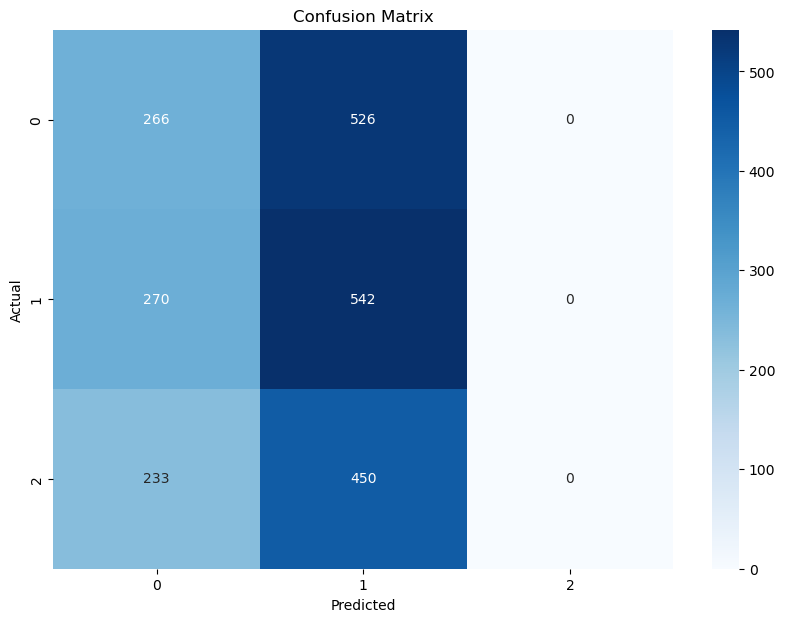

Confusion matrix saved to ./results/confusion_matrix.png


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/confusion_matrix.png")
